In [1]:
%matplotlib notebook
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.mri_viewer import MRIViewer
from utils.data_utils import im_path_to_arr
from utils.config import Config
from utils.dice_score import dice_score
from models.fcn_concat import FCN_Concat

In [2]:
ex_path = '/local-scratch/romain_scratch/brats2017/train/'
patient = 'Brats17_2013_10_1'
patient_path = os.path.join(ex_path, patient)
label_path = os.path.join(patient_path, patient + '_seg.nii')
label = im_path_to_arr(label_path)
patient_path = patient_path.encode('utf-8')

In [3]:
os.listdir(patient_path)

[b'Brats17_2013_10_1_t1ce.nii',
 b'Brats17_2013_10_1_t2.nii',
 b'Brats17_2013_10_1_t1.nii',
 b'Brats17_2013_10_1_flair.nii',
 b'Brats17_2013_10_1_seg.nii']

In [4]:
config_path = 'config_files/fcn_train_concat_2017_v42.cfg'
config = Config(config_path)
model = FCN_Concat(config)

In [5]:
saver = tf.train.Saver()
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
with tf.Session() as sess:
    saver.restore(sess, config.ckpt_path)
    pred = model.run_pred_single_example(sess, patient_path)
    pred[pred == 3] = 4

INFO:tensorflow:Restoring parameters from ckpt/fcn_brats_concat_2017_v42.ckpt


In [6]:
mr = MRIViewer(pred, label, cmap=None, title1='prediction', title2='ground truth')

TypeError: __init__() missing 2 required positional arguments: 'im3' and 'im4'

In [7]:
def get_dice_scores(p, y):
    dice_whole = dice_score(y, pred)
    fpred_core = (p == 1) + (p == 4)
    fy_core = (y == 1) + (y == 4)
    dice_core = dice_score(fy_core, fpred_core)
    fpred_enhancing = p == 4
    fy_enhancing = y == 4
    dice_enhancing = dice_score(fy_enhancing, fpred_enhancing)
    print('whole: %f ... core: %f ... enhancing: %f ...'%(dice_whole, dice_core, dice_enhancing))

In [8]:
get_dice_scores(pred, label)

whole: 0.894028 ... core: 0.949889 ... enhancing: 0.850837 ...


In [10]:
patient_path = patient_path.decode('utf-8')
flair_path = os.path.join(patient_path, patient + '_flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, patient + '_t1ce.nii')
t1post = im_path_to_arr(t1post_path)

<IPython.core.display.Javascript object>


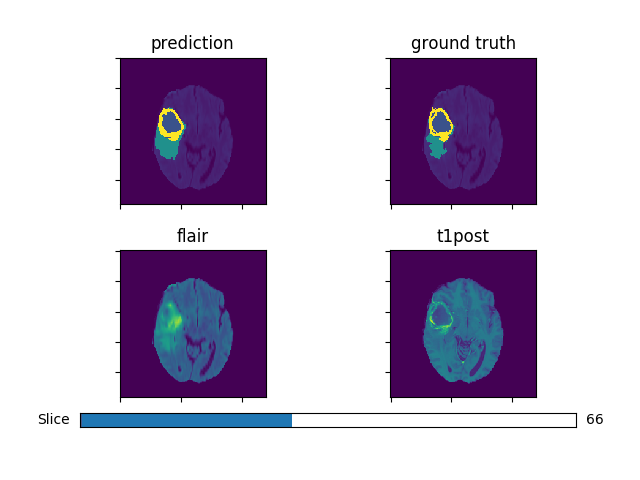

In [12]:
flair_pred = np.array(flair)
flair_label = np.array(flair)
flair_pred[pred == 1] = 1000
flair_pred[pred == 2] = 2000
flair_pred[pred == 4] = 4000
flair_label[label == 1] = 1000
flair_label[label == 2] = 2000
flair_label[label == 4] = 4000
MRIViewer(flair_pred, flair_label, flair, t1post, cmap=None, title1='prediction', title2='ground truth', title3='flair', title4='t1post')